<br><br><br><br><br><br>

# Fairness in AI — Ethical Implications of ML Models


### Definitions of fairness

Legal definitions
- Disparate treatment - intentional discrimination.
- Disparate impact - unintentional - applies to ML models that learn from data

The Four-Fifths rule states that if the selection rate for a certain group is less than 80 percent of that of the group with the highest selection rate, there is adverse impact on that group. Traditional approach has been through Unawareness. We ignore protected attributes (gender, age, race, etc.) when training ML models - however due to correlated variables bias still creeps in. 

We will show this with example. We will load a dataset, remove protected attributes and train a ML model for predicting loan approval. Then combine the data with protected attributes and see if they are related to predictions made by ML model.

Metrics for AI fairness:
- **Demographic parity** - selection rate for each group is same. If 30 percent of the applicants are women, then 30 percent of the pool of approved applicants ought to be women. This is measured through **disparate impact ration** or **statistical parity difference**
- **Equal opportunity** - Individuals who qualify for a desirable outcome should have an equal chance of being correctly classified for this outcome. True Positive Rate (TPR) is the same for all groups as required by Equal Opportunity.
- **Equal odds/accuracy** - correctly identify the positive outcome at equal rates across groups (same as in Equal Opportunity), but also miss-classify the positive outcome at equal rates across groups (creating the same proportion of False Positives across groups).
- **Theil index** is a statistic used to measure economic inequality. The Theil index measures an entropic "distance" the population is away from the "ideal" egalitarian state of everyone having the same income. The numerical result is in terms of negative entropy so that a higher number indicates more order that is further away from the "ideal" of maximum disorder.
- **Individual Fairness** - similar individuals should be treated similarly.
- **Counterfactual fairness** provides a way to check the possible impact of replacing only the sensitive attribute. It provides a way of explaining the impact of bias via a causal graph.

## Load the dataset and split train/test sets

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#np.random.seed(111)
data = pd.read_csv('LoanApproval-VERSION-2.csv')
data = data.dropna()
data = data.drop('Loan_ID', axis=1)

data.loc[data.Loan_Status == 'Y', 'Loan_Status'] = 1
data.loc[data.Loan_Status == 'N', 'Loan_Status'] = 0
data.loc[data.Gender == 'Male', 'Gender'] = 1
data.loc[data.Gender == 'Female', 'Gender'] = 0
data.loc[data.Married == 'Yes', 'Married'] = 1
data.loc[data.Married == 'No', 'Married'] = 0

# Replace the categorical values with the numeric equivalents that we have above
categoricalFeatures = ['Property_Area', 'Dependents', 'Education', 'Self_Employed']
# Iterate through the list of categorical features and one hot encode them.
for feature in categoricalFeatures:
    onehot = pd.get_dummies(data[feature], prefix=feature)
    data = data.drop(feature, axis=1)
    data = data.join(onehot)

data.head()

,Gender,Married,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes
1,1,1,4583,1508.0,128.0,360.0,1.0,0,1,0,0,0,1,0,0,1,0,1,0
2,1,1,3000,0.0,66.0,360.0,1.0,1,0,0,1,1,0,0,0,1,0,0,1
3,1,1,2583,2358.0,120.0,360.0,1.0,1,0,0,1,1,0,0,0,0,1,1,0
4,1,0,6000,0.0,141.0,360.0,1.0,1,0,0,1,1,0,0,0,1,0,1,0
5,1,1,5417,4196.0,267.0,360.0,1.0,1,0,0,1,0,0,1,0,1,0,0,1


## Drop the protected attributes

We will use the excellent PyCaret library for quick feature engineering and model building.

In [55]:
from pycaret.classification import *

data_4model = data.drop(columns=['Married', 'Gender'], axis=1)

# code from - https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas

msk = np.random.rand(len(data_4model)) < 0.8
data_train = data_4model[msk]
data_test = data_4model[~msk]
data_test_orig = data[~msk]
data_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes
2,3000,0.0,66.0,360.0,1.0,1,0,0,1,1,0,0,0,1,0,0,1
4,6000,0.0,141.0,360.0,1.0,1,0,0,1,1,0,0,0,1,0,1,0
5,5417,4196.0,267.0,360.0,1.0,1,0,0,1,0,0,1,0,1,0,0,1
6,2333,1516.0,95.0,360.0,1.0,1,0,0,1,1,0,0,0,0,1,1,0
8,4006,1526.0,168.0,360.0,1.0,1,0,0,1,0,0,1,0,1,0,1,0


## Build the RandomForest classifier ML model using PyCaret

PyCaret is anm extremely handy low-code ML framework that incorporates best-practices in ML model development and provides and easy to use interface for data scientists.

In [56]:
s = setup(data_train, target = 'Loan_Status', silent=True)

,Description,Value
0,session_id,7622
1,Target,Loan_Status
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(384, 17)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [57]:
# return best model
rf_model = create_model('rf', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7593,0.8526,0.8857,0.7750,0.8267,0.4384,0.4490
1,0.7778,0.7549,0.9143,0.7805,0.8421,0.4749,0.4921
2,0.7407,0.8356,0.8611,0.7750,0.8158,0.3824,0.3884
3,0.7358,0.7135,0.8857,0.7561,0.8158,0.3592,0.3736
4,0.7925,0.8190,0.9143,0.8000,0.8533,0.5038,0.5172
Mean,0.7612,0.7951,0.8922,0.7773,0.8307,0.4317,0.4441
SD,0.0215,0.0525,0.0201,0.0140,0.0149,0.0544,0.0561


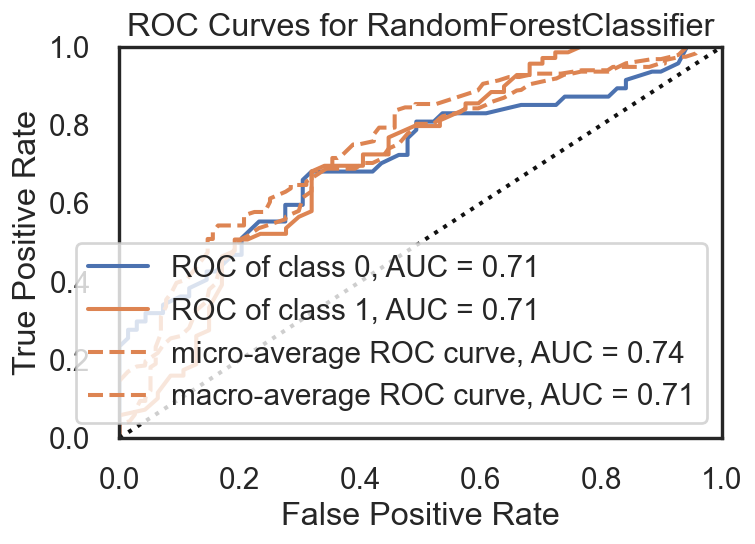

In [58]:
model_select = rf_model
plot_model(model_select, scale=1.8)

## Make the predictions on test dataset

In [59]:
# generate predictions on unseen data
# this will create a Label column
predictions = predict_model(model_select, data = data_test)
predictions

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Label,Score
1,4583,1508.0,128.0,360.0,1.0,0,1,0,0,0,1,0,0,1,0,1,0,1,0.89
3,2583,2358.0,120.0,360.0,1.0,1,0,0,1,1,0,0,0,0,1,1,0,1,0.90
7,3036,2504.0,158.0,360.0,0.0,0,0,1,0,0,0,0,1,1,0,1,0,0,0.72
15,4950,0.0,125.0,360.0,1.0,1,0,0,1,1,0,0,0,1,0,1,0,1,0.95
18,4887,0.0,133.0,360.0,1.0,0,1,0,0,1,0,0,0,0,1,1,0,1,0.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,3159,461.0,108.0,84.0,1.0,1,0,0,1,0,0,1,0,1,0,1,0,1,0.88
595,3833,0.0,110.0,360.0,1.0,1,1,0,0,1,0,0,0,0,1,1,0,0,0.64
598,9963,0.0,180.0,360.0,1.0,1,1,0,0,1,0,0,0,1,0,0,1,1,0.72
609,2900,0.0,71.0,360.0,1.0,1,1,0,0,1,0,0,0,1,0,1,0,0,0.73


## Re-insert protected attributes with predictions dataframe

In [60]:
# lets evaluate predictions for fairness
predictions = predictions.drop(['Loan_Status', 'Score'], axis=1)
predictions = predictions.rename(columns = {'Label': 'Loan_Status'}, inplace = False)

# add gender and married columns
predictions['Gender'] = data_test_orig['Gender']
predictions['Married'] = data_test_orig['Married']
predictions

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Loan_Status,Gender,Married
1,4583,1508.0,128.0,360.0,1.0,1,0,0,0,1,0,0,1,0,1,0,1,1,1
3,2583,2358.0,120.0,360.0,1.0,0,0,1,1,0,0,0,0,1,1,0,1,1,1
7,3036,2504.0,158.0,360.0,0.0,0,1,0,0,0,0,1,1,0,1,0,0,1,1
15,4950,0.0,125.0,360.0,1.0,0,0,1,1,0,0,0,1,0,1,0,1,1,0
18,4887,0.0,133.0,360.0,1.0,1,0,0,1,0,0,0,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,3159,461.0,108.0,84.0,1.0,0,0,1,0,0,1,0,1,0,1,0,1,1,1
595,3833,0.0,110.0,360.0,1.0,1,0,0,1,0,0,0,0,1,1,0,0,1,0
598,9963,0.0,180.0,360.0,1.0,1,0,0,1,0,0,0,1,0,0,1,1,1,1
609,2900,0.0,71.0,360.0,1.0,1,0,0,1,0,0,0,1,0,1,0,0,0,0


## Analyze distribution of protected attributes in predictions

Analyzing the dataset for protected attributes - Gender, Married
-------------------------


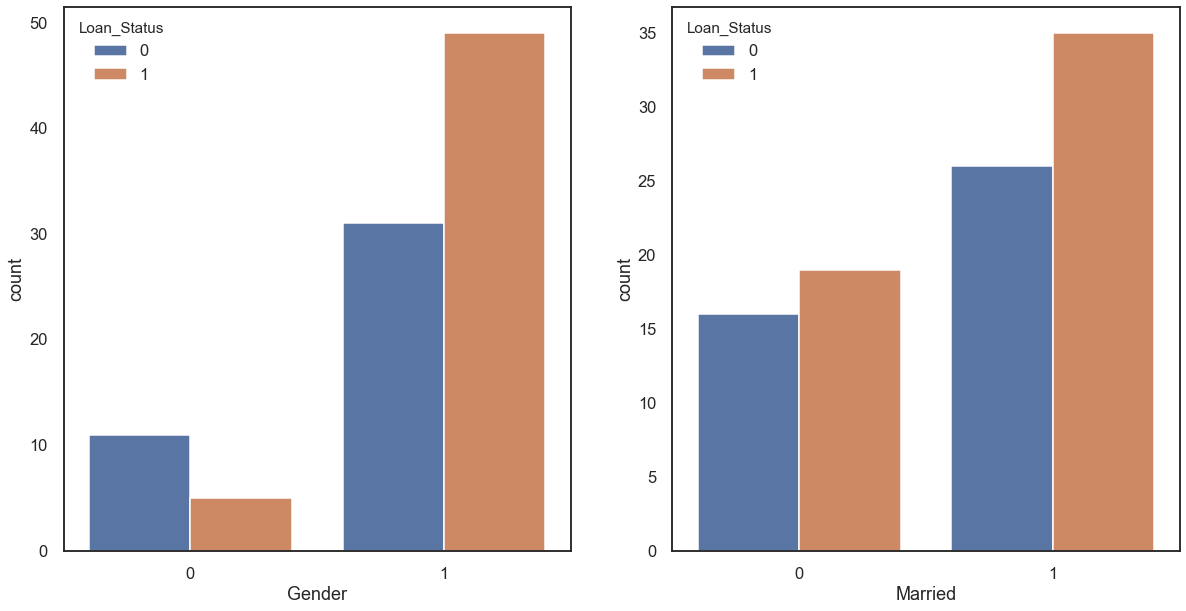

In [62]:
def show_plots(data, categorical_columns, label):
    sns.set(style="white", context="talk")
    sns.color_palette("rocket")
    fig,axes = plt.subplots(1,2,figsize=(20,10))
    for idx,cat_col in enumerate(categorical_columns):
        sns.countplot(x=cat_col, data=data, hue=label, ax=axes[idx])
    plt.subplots_adjust(hspace=0.5)
    plt.show()

print('Analyzing the dataset for protected attributes - Gender, Married')
print('-'*25)
show_plots(data_test_orig, ['Gender', 'Married'], 'Loan_Status')

In [64]:
def get_fairness_metrics(predictions):
    # ratio for a group = group outcomes/group count
    unpr_df = predictions[predictions.Gender == 0]
    num_unpr = len(unpr_df)
    unpr_outcomes = len(unpr_df[unpr_df.Loan_Status == 1])
    unpr_ratio = unpr_outcomes/num_unpr
    
    priv_df = predictions[predictions.Gender == 1]
    num_priv = len(priv_df)
    priv_outcomes = len(priv_df[priv_df.Loan_Status == 1])
    priv_ratio = priv_outcomes/num_priv
    
    print("Disparate impact ratio for Gender vs Loan Status Prediction = ", (unpr_ratio/priv_ratio))
    print("Statistical parity difference for Gender vs Loan Status Prediction = ", (unpr_ratio - priv_ratio))
    
get_fairness_metrics(data_test_orig)

Disparate impact ratio for Gender vs Loan Status Prediction =  0.5102040816326531
Statistical parity difference for Gender vs Loan Status Prediction =  -0.30000000000000004


## Using IBM AI fairness 360 toolkit

AI Fairness concepts
- Unawareness
- Demographic parity
- Equal opportunity
- Equal odds

## Tune the original training dataframe for consumption by AIF360

In [65]:
import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.explainers import MetricTextExplainer

# create a dataset compatible with aif360 - hopefully they will remove this step in future
predDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=data_test_orig,
    label_names=['Loan_Status'],
    protected_attribute_names=['Gender'])

p = [{'Gender': 1}]
u = [{'Gender': 0}]

cm = BinaryLabelDatasetMetric(predDataset, privileged_groups=p, unprivileged_groups=u)
text_exp_tr = MetricTextExplainer(cm)

print(text_exp_tr.disparate_impact())
print(text_exp_tr.statistical_parity_difference())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.5102040816326531
Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.30000000000000004
